In [1]:
import numpy as np
import pandas as pd

batting = pd.read_csv('./Data/Batting.csv')

In [2]:
batting = batting[ (batting['yearID'] >=1987) & (batting['yearID'] <=2012)]
batting = batting [ (batting['AB'] > 100) & (batting['G'] > 81)]
batting = batting.drop(['stint', 'teamID', 'lgID', 'G_batting', 'G_old'], axis = 1)

In [3]:
allstars = pd.read_csv('./Data/AllstarFull.csv')
allstars = allstars[ (allstars['yearID'] >=1987) & (allstars['yearID'] <=2012)]
allstars = allstars[['playerID', 'yearID', 'gameID']]

In [4]:
merged = pd.merge(batting, allstars, how = 'left', on = ['playerID', 'yearID'])

In [5]:
merged['All-Star'] = np.where(merged['gameID'].notnull() , True, False)

In [6]:
merged['1B'] = (merged['H'] - (merged['2B'] + merged['3B'] + merged['HR']))
merged['SLG'] = (merged['1B'] + (2*merged['2B']) + (3*merged['3B']) + (4*merged['HR'])) / merged['AB']
merged['AVG'] = merged['H'] / merged['AB']
merged['OBP'] = (merged['H'] + merged['BB'] + merged['HBP']) / (merged['AB'] + merged['BB'] + merged['HBP'] + merged['SF'])
merged['ISO'] = merged['SLG'] - merged['AVG']
merged['OPS'] = merged['OBP'] + merged['SLG']
merged = merged.drop(['playerID', 'yearID', 'gameID', 'G', 'SF', 'SH', 'HBP', 'GIDP', 'CS', 'IBB'], axis=1)
merged

,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,All-Star,1B,SLG,AVG,OBP,ISO,OPS
0,244.0,33.0,68.0,14.0,1.0,12.0,41.0,3.0,9.0,28.0,False,41.0,0.491803,0.278689,0.298450,0.213115,0.790253
1,345.0,41.0,86.0,17.0,3.0,9.0,33.0,3.0,16.0,98.0,False,57.0,0.394203,0.249275,0.290761,0.144928,0.684964
2,420.0,60.0,107.0,18.0,7.0,17.0,60.0,4.0,36.0,110.0,False,65.0,0.452381,0.254762,0.317597,0.197619,0.769978
3,320.0,37.0,81.0,18.0,7.0,8.0,33.0,3.0,22.0,99.0,False,48.0,0.428125,0.253125,0.307246,0.175000,0.735371
4,252.0,35.0,69.0,18.0,2.0,6.0,30.0,3.0,14.0,68.0,False,43.0,0.432540,0.273810,0.314607,0.158730,0.747146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7493,541.0,77.0,129.0,28.0,2.0,10.0,75.0,24.0,92.0,107.0,False,89.0,0.353050,0.238447,0.345679,0.114603,0.698729
7494,588.0,99.0,158.0,46.0,6.0,20.0,91.0,19.0,77.0,128.0,False,86.0,0.469388,0.268707,0.352679,0.200680,0.822066
7495,560.0,88.0,151.0,39.0,7.0,20.0,74.0,14.0,97.0,103.0,False,85.0,0.471429,0.269643,0.376877,0.201786,0.848305
7496,392.0,46.0,108.0,19.0,1.0,3.0,43.0,2.0,25.0,60.0,False,85.0,0.352041,0.275510,0.322353,0.076531,0.674394


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline


In [8]:
merged_x = merged.drop('All-Star', 1)
merged_y = merged['All-Star']

In [9]:
from sklearn.model_selection import train_test_split

merged_x_train, merged_x_test, merged_y_train, merged_y_test = train_test_split(merged_x, merged_y, random_state = 42, train_size = 0.7)

In [10]:
print(len(merged_x), len(merged_x_test), len(merged_x_train))

7498 2250 5248


In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1', 'l2'],
         'C': [0.01, 0.1, 1, 10]}

log_regression_model = LogisticRegression(class_weight='balanced', max_iter = 700)

grid_search_log_reg = GridSearchCV(log_regression_model, 
                                    param_grid=params,  
                                   cv=10, 
                                   n_jobs = 2  
                                   )
grid_search_log_reg.fit(merged_x_train, merged_y_train)

best_log_reg = grid_search_log_reg.best_estimator_

print(grid_search_log_reg.best_params_)

{'C': 10, 'penalty': 'l2'}


In [13]:
import sklearn.metrics as sklmetrics

merged_pred_Y = best_log_reg.predict(merged_x_test)

print('The accuracy score is {}'.format(sklmetrics.accuracy_score(merged_y_test, merged_pred_Y)))


The accuracy score is 0.7875555555555556


[[1526  412]
 [  66  246]]


Text(91.68, 0.5, 'True Value')

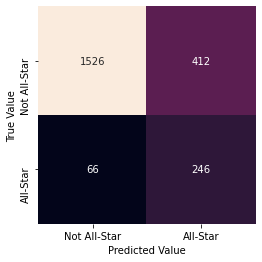

In [14]:
conf_mat = sklmetrics.confusion_matrix(merged_y_test, merged_pred_Y)
print(conf_mat)

sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Not All-Star','All-Star'], 
                                                            yticklabels = ['Not All-Star','All-Star'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

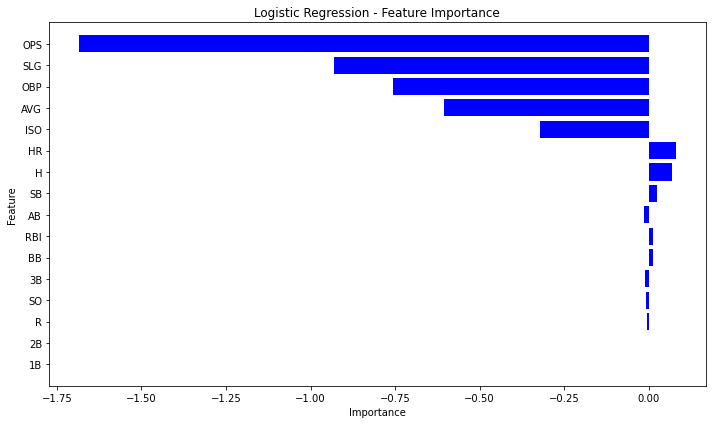

In [15]:
def plot_feature_importance_coeff(model, Xnames, cls_nm = None):

    imp_features = pd.DataFrame(np.column_stack((Xnames, model.coef_.ravel())), columns = ['feature', 'importance'])
    imp_features[['importance']] = imp_features[['importance']].astype(float)
    imp_features[['abs_importance']] = imp_features[['importance']].abs()
    imp_features = imp_features.sort_values(by = ['abs_importance'], ascending = [1])
    plt.figure(figsize=(10,6))
    plt.title(cls_nm + " - Feature Importance")
    plt.barh(range(imp_features.shape[0]), imp_features['importance'],
            color="b", align="center")
    plt.yticks(range(imp_features.shape[0]), imp_features['feature'], )
    plt.ylim([-1, imp_features.shape[0]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout() 
    plt.savefig(cls_nm + "_feature_imp.png", bbox_inches='tight')
    plt.show()
    
plot_feature_importance_coeff(best_log_reg, merged_x_train.columns, cls_nm="Logistic Regression")

In [16]:
from sklearn.tree import DecisionTreeClassifier

dec_tree_model = DecisionTreeClassifier(class_weight='balanced')

dec_tree_model.fit(merged_x_train, merged_y_train)

DecisionTreeClassifier(class_weight='balanced')

In [17]:
params = {'max_depth':[3,4,5],
          'max_features':['auto','log2',None]}

grid_search_dec_tree = GridSearchCV(dec_tree_model, 
                                    param_grid=params,  
                                   cv=3, 
                                   n_jobs = 1 
                                   )

grid_search_dec_tree.fit(merged_x_train, merged_y_train)

best_dec_tree_cv = grid_search_dec_tree.best_estimator_

print(grid_search_dec_tree.best_params_)

{'max_depth': 5, 'max_features': None}


In [18]:
merged_y_pred = best_dec_tree_cv.predict(merged_x_test)

print('The accuracy score is {}'.format(sklmetrics.accuracy_score(merged_y_test, merged_y_pred)))


The accuracy score is 0.7626666666666667


[[1458  480]
 [  54  258]]


Text(91.68, 0.5, 'True Value')

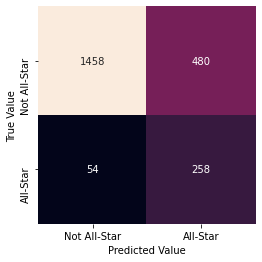

In [19]:
conf_mat = sklmetrics.confusion_matrix(merged_y_test, merged_y_pred)
print(conf_mat)

sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Not All-Star','All-Star'], 
                                                            yticklabels = ['Not All-Star','All-Star'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [20]:
def plot_feature_importance(model, Xnames, cls_nm = None):

    imp_features = pd.DataFrame(np.column_stack((Xnames, model.feature_importances_)), columns = ['feature', 'importance'])
    imp_features[['importance']] = imp_features[['importance']].astype(float)
    imp_features[['abs_importance']] = imp_features[['importance']].abs()
    imp_features = imp_features.sort_values(by = ['abs_importance'], ascending = [1])
    imp_features = imp_features.iloc[10:]
    plt.figure(figsize=(10,6))
    plt.title(cls_nm + " - Feature Importance")
    plt.barh(range(imp_features.shape[0]), imp_features['importance'],
            color="b", align="center")
    plt.yticks(range(imp_features.shape[0]), imp_features['feature'], )
    plt.ylim([-1, imp_features.shape[0]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout() 
    plt.savefig(cls_nm + "_feature_imp.png", bbox_inches='tight')
    plt.show()

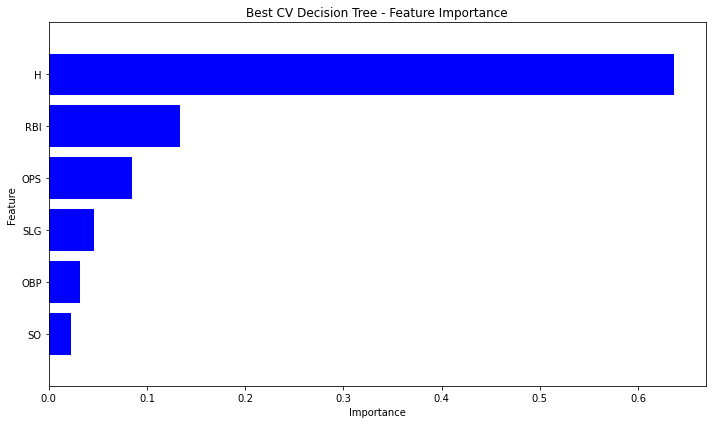

In [21]:
plot_feature_importance(best_dec_tree_cv, merged_x.columns, cls_nm='Best CV Decision Tree')

In [22]:
importances = best_dec_tree_cv.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(merged_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 2 (0.637105)
2. feature 6 (0.133315)
3. feature 15 (0.084556)
4. feature 11 (0.046521)
5. feature 13 (0.031804)
6. feature 9 (0.023052)
7. feature 12 (0.016457)
8. feature 5 (0.010783)
9. feature 8 (0.006195)
10. feature 3 (0.003851)
11. feature 7 (0.003446)
12. feature 1 (0.002914)
13. feature 14 (0.000000)
14. feature 10 (0.000000)
15. feature 4 (0.000000)
16. feature 0 (0.000000)
